## CHME0031: Programming with Python for Health Research Assessment 2022-2023


This assessment focused on the WHO Mortality Database, a datasource used for comparative epidemiological studies of mortality by cause. This database is comprised of files describing each country's population and number of deaths by sex, age, cause, and year from 1950 to 2020. The underlying cause of death is coded according to the International Classification of Disease (ICD9), either by the 8th (ICD8), 9th (ICD9), or 10th (ICD10) version. Several versions of ICD must be used as some countries, particularly those in the developing world, do not implement the ICD10 updates. 

The aim of this assessment was to review the WHO mortality data with particular attention paid to COVID-19 mortality. Further objectives looked at investigating the best ways to filter and visualise the data to make the information accessible to scientists and audiences alike

In [1]:
#Import Relevant Modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
import re  
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
#For scatterplot in Q6  in regards to grid 
#Warning: plt.colorbar() MatplotlibDeprecationWarning: \
#Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 \
#and will be removed two minor releases later; please call grid(False) first.


In [94]:
#Inspection and Cleaning of Data
##NOTE: Inspection and Cleaning of ICD10 mortality files (as a whole) is done in Q3

country_codes = pd.read_csv(r"C:\Users\35387\Desktop\Python Assessment\mort_country_codes\country_codes.csv")
#Each column should have a unique country code, check to ensure this 
country_codes.duplicated(subset = ["country"]) #All False therefore no duplicates
country_codes.country.unique() #confirmed
#There are multiple values for UK - UK total as well as subdivisions. 
#The subdivisions will be dropped from ALL files and total UK will be solely considered
uk_countries_subdivision = ["United Kingdom, England and Wales", \
                            "United Kingdom, Northern Ireland", \
                            "United Kingdom, Scotland"]
country_codes = country_codes[country_codes.name.isin(uk_countries_subdivision) == False]
country_codes.name.unique() #confirmed
country_codes = country_codes.rename(columns = {"country": "Country_Num", \
                                                "name": "Country_Name"}) #for clarity
country_codes

country_populations = pd.read_csv(r"C:\Users\35387\Desktop\Python Assessment\mort_pop\pop.csv") 
#Reference Population and Live Births
country_populations = country_populations.rename(columns = {"Country": "Country_Num", \
                                                            "Pop1": "Pop_All_Ages", \
                                                            "Lb": "Live Births"}) #for clarity
country_populations.Sex.unique() #1,2,9 - 9 is unknown sex and could lead to confusing results, should be dropped 
country_populations_df = country_populations[country_populations["Sex"] != 9]
country_populations_df = pd.merge(country_codes, country_populations_df, how = "inner", \
                                  on = "Country_Num") #add country names column to population df 
country_populations_df = country_populations_df[country_populations_df.Country_Name.isin\
                                                (uk_countries_subdivision) == False]
country_populations_df.Country_Name.unique() #confirmed dropped

mortality_cause_icd9 = pd.read_csv(r"C:\Users\35387\Desktop\Python Assessment\morticd09\Morticd9.csv", \
                                   dtype = {"SubDiv": object})
#Dtype warning: Columns (2) have mixed types, problem column set to solely object
mortality_cause_icd9 = mortality_cause_icd9.rename(columns = {"Cause": "Cause_of_Death", \
                                                              "Country": "Country_Num", "Deaths1": "Death_All_Ages", \
                                                              "Deaths26": "Death_Unspecified_Age"}) #for clarity 
mortality_cause_icd9 = mortality_cause_icd9[mortality_cause_icd9["Sex"] != 9] #same as above
mortality_cause_icd9 = pd.merge(country_codes, mortality_cause_icd9, \
                                how = "inner", on = "Country_Num")
mortality_cause_icd9  = mortality_cause_icd9 [mortality_cause_icd9.Country_Name.\
                                              isin(uk_countries_subdivision) == False]
mortality_cause_icd9.Country_Name.unique() #confirmed dropped

mortality_cause_icd10_p5 = pd.read_csv(r"C:\Users\35387\Desktop\Python Assessment\morticd10\Morticd10_part5.csv", \
                                       dtype = {"SubDiv": object})
mortality_cause_icd10_p5 = mortality_cause_icd10_p5.rename(columns = {"Cause": "Cause_of_Death", \
                                                                      "Country": "Country_Num", \
                                                                      "Deaths1": "Death_All_Ages", \
                                                                      "Deaths26": "Death_Unspecified_Age"}) \
#for clarity 
mortality_cause_icd10_p5 = mortality_cause_icd10_p5[mortality_cause_icd10_p5["Sex"] != 9] #same as above
mortality_cause_icd10_p5= pd.merge(country_codes, mortality_cause_icd10_p5, how = "inner", \
                                   on = "Country_Num")
mortality_cause_icd10_p5 = mortality_cause_icd10_p5[mortality_cause_icd10_p5.Country_Name.\
                                                    isin(uk_countries_subdivision) == False]
mortality_cause_icd10_p5.Country_Name.unique() #confirmed dropped

who_additional_info = pd.read_csv(r"C:\Users\35387\Desktop\Python Assessment\additional_info.csv")
who_additional_info = who_additional_info.rename(columns = {"country": "Country_Num"})
who_additional_info.isnull().values.sum() #checking for missing values 
#Drop the rows where at least one element is missin
who_additional_info_nonull = who_additional_info.dropna()
who_additional_info_nonull = pd.merge(country_codes, who_additional_info_nonull, \
                                      how = "inner", on = "Country_Num")
who_additional_info_nonull = who_additional_info_nonull[who_additional_info_nonull.Country_Name.\
                                                        isin(uk_countries_subdivision) == False]
#who_additional_info_nonull.Country_Name.unique() #confirmed dropped


## Question 1 - Population Sizes in 2020

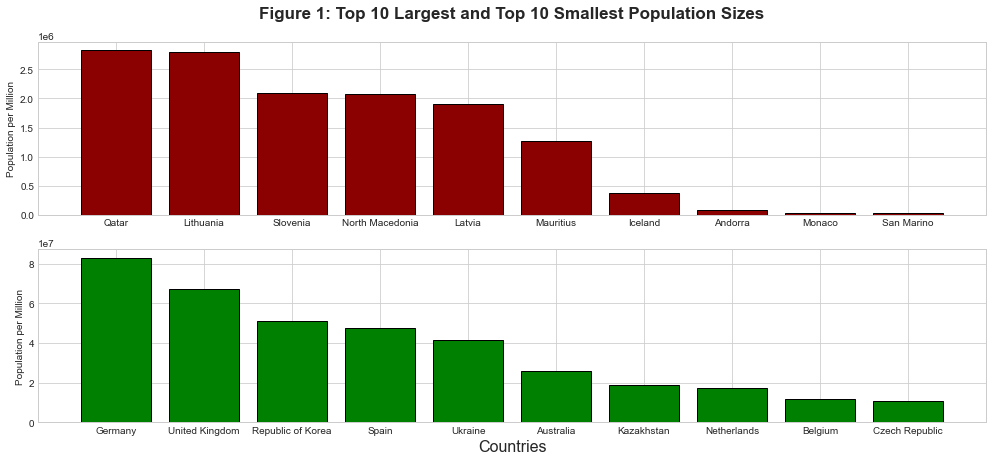

In [95]:
country_populations_2020 = country_populations_df[country_populations_df["Year"] == 2020]
#Need to combine both sexes to get total population - ie get the sum of the populations for each country 
country_populations_2020_sum = country_populations_2020.groupby("Country_Name").agg({"Pop_All_Ages": "sum"}).reset_index()
country_populations_2020_sum["Pop_All_Ages"] = country_populations_2020_sum["Pop_All_Ages"].astype("int") #do not want decimals as part of the population 
country_populations_2020_sum = country_populations_2020_sum.sort_values("Pop_All_Ages", ascending = False) #sorting to see the largest population first 


highest_pop = country_populations_2020_sum.head(10)
lowest_pop = country_populations_2020_sum.tail(10)

fig, axes = plt.subplots(2, 1, figsize = (17, 7), sharey = False)
sns.set_style("whitegrid")
axes[0].bar(lowest_pop["Country_Name"], lowest_pop["Pop_All_Ages"], color = "darkred", edgecolor = "black")
axes[1].bar(highest_pop["Country_Name"], highest_pop["Pop_All_Ages"], color = "green", edgecolor = "black")
axes[1].set_xlabel("Countries", fontsize = 16)
axes[0].set_ylabel("Population per Million")
axes[1].set_ylabel("Population per Million")
plt.title("Figure 1: Top 10 Smallest and Top 10 Largest Population Sizes", y=2.3, fontsize = 17, fontweight = "bold")
plt.show()

In [96]:
country_populations_2020_sum.iloc[::-1].reset_index(drop = True).head(10) #top 10 highest populations

,Country_Name,Pop_All_Ages
0,San Marino,33615
1,Monaco,37309
2,Andorra,82317
3,Iceland,366463
4,Mauritius,1265740
5,Latvia,1900449
6,North Macedonia,2072531
7,Slovenia,2100126
8,Lithuania,2794885
9,Qatar,2833681


In [97]:
country_populations_2020_sum.head(10).reset_index(drop = True) #top 10 lowest populations

,Country_Name,Pop_All_Ages
0,Germany,83160871
1,United Kingdom,67078534
2,Republic of Korea,51349259
3,Spain,47355684
4,Ukraine,41575748
5,Australia,25687041
6,Kazakhstan,18755665
7,Netherlands,17512079
8,Belgium,11544256
9,Czech Republic,10700155


   To dissect the smallest and largest population sizes, the "country_population_df" dataframe was used. This dataframe contains the reference population and live births broken down by age for each country. This dataframe was filtered to only include information from 2020, the year COVID-19 became notably widespread. The populations for each country were sex-specific so a lambda function was used to sum for the total population for each country. 
    
   Figure 1 and the corresponding tables show the countries with the smallest population sizes and the largest population sizes in 2020. The smallest population size was San Marino (n=33615), followed closely by Monaco (n=37309) then Andorra (n=82317). In contrast, Germany had the highest population (n=83.16million), over 2400 times larger than the smallest population of San Marino. The United Kingdom (UK) (encompassing Northern Ireland, England, Scotland, and Wales) had the second largest (n=67.08million), with the Republic of Korea having the third largest (n=51.35million).  

## Question 2 - ICD9 Causes of Death in UK in 1999

In [9]:
mortality_icd9_99_uk = mortality_cause_icd9[(mortality_cause_icd9["Year"] == 1999) & \
                                            (mortality_cause_icd9["Country_Name"] == "United Kingdom") \
                                           ].reset_index(drop = True) #filtering from relevant year and country

#Make age groups by 20 year dividends

mortality_icd9_99_uk["Death_All_Ages"] = mortality_icd9_99_uk["Death_All_Ages"]
age_groups = ["Deaths0_19yrs", "Deaths20_39yrs", "Deaths40_59yrs", "Deaths60_79yrs", "Deaths80_plus", "Infant_Deaths"]
age_columns = ["Deaths2", "Deaths3", "Deaths4", "Deaths5", "Deaths6", "Deaths7", \
               "Deaths8", "Deaths9", "Deaths10", "Deaths11", "Deaths12", "Deaths13", \
               "Deaths14", "Deaths15", "Deaths16", "Deaths17", "Deaths18", "Deaths19", \
               "Deaths20", "Deaths21", "Deaths22", "Deaths23", "Deaths24", "Deaths25", \
               "IM_Deaths1", "IM_Deaths2", "IM_Deaths3", "IM_Deaths4"]

for i, group in enumerate(age_groups):
     mortality_icd9_99_uk[group] = sum([mortality_icd9_99_uk[col] for col in age_columns[i*4:(i+1)*4]])

        
mortuk_99_agecat = mortality_icd9_99_uk[["Country_Num", "Country_Name", "Cause_of_Death", "Sex", "Death_All_Ages", \
                                         "Deaths0_19yrs", "Deaths20_39yrs", "Deaths40_59yrs", "Deaths60_79yrs", \
                                         "Deaths80_plus", "Infant_Deaths"]]
#Taking only the relevant columns
mortuk_99_agecat.reset_index(drop = True).head() #"drop = True" prevents the old index being added as a column


,Country_Num,Country_Name,Cause_of_Death,Sex,Death_All_Ages,Deaths0_19yrs,Deaths20_39yrs,Deaths40_59yrs,Deaths60_79yrs,Deaths80_plus,Infant_Deaths
0,4308,United Kingdom,140,1,14,0.0,0.0,0.0,3.0,6.0,NaN
1,4308,United Kingdom,140,2,12,0.0,0.0,0.0,0.0,3.0,NaN
2,4308,United Kingdom,141,1,281,0.0,0.0,7.0,114.0,125.0,NaN
3,4308,United Kingdom,141,2,171,0.0,0.0,6.0,24.0,75.0,NaN
4,4308,United Kingdom,1410,1,17,0.0,0.0,0.0,7.0,10.0,NaN


In [10]:
#ICD9 Basic Tabulation List (BTL) and corresponding Cause
icd9_btl_codes = {
    "^B00": "All Causes",
    "^B01\d{0,1}": "Intestinal Infectious Diseases",
    "^B02\d{0,1}": "Tuberculosis",
    "^B03\d{0,1}": "Other Bacterial Diseases",
    "^B04\d{0,1}": "Viral Diseases",
    "^B05\d{0,1}": "Arthropod-Borne Diseases",
    "^B06\d{0,1}": "Venereal Diseases",
    "^B07\d{0,1}": "Other Infectious/Parasitic Diseases",
    "^B08\d{0,1}": "Malignant Neoplasms of Lip, Oral Cavity, and Pharynx",
    "^B09\d{0,1}": "Malignant Neoplasms of Digestive Organs and Peritoneum",
    "^B10\d{0,1}": "Malignant Neoplasms of Respiratory and Introthoracic Organs",
    "^B11\d{0,1}": "Malignant Neoplasms of Bone, Connective Tissue, Skin, and Breast",
    "^B12\d{0,1}": "Malignant Neoplasms of Genitourinary Organs",
    "^B13\d{0,1}": "Malignant Neoplasms of Other and Unspecified Sites",
    "^B14\d{0,1}": "Malignant Neoplasms of Lymphatic and Haemopoetic Tissue",
    "^B15\d{0,1}": "Benign Neoplasms",
    "^B16\d{0,1}": "Carcinoma in Situ",
    "^B17\d{0,1}": "Other and Unspecified Neoplasms",
    "^B18\d{0,1}": "Endocrine and Metabolic Diseases, Immunity Disorders",
    "^B19\d{0,1}": "Nutritional Deficiencies",
    "^B20\d{0,1}": "Diseases of Blood and Blood Forming Organs",
    "^B21\d{0,1}": "Mental Disorders",
    "^B22\d{0,1}": "Diseases of the Nervous System",
    "^B23\d{0,1}": "Diseases of the Eye and Adnexa",
    "^B24\d{0,1}": "Diseases of the Ear and Mastoid Process",
    "^B25\d{0,1}": "Rheumatic Fever and Rheumatic Heart Diseases",
    "^B26\d{0,1}": "Hypertensive Disease",
    "^B27\d{0,1}": "Ischaemic Heart Disease",
    "^B28\d{0,1}": "Diseases of Pulmonary Circulation and Other Forms of Heart Disease",
    "^B29\d{0,1}": "Cerebrovascular Disease",
    "^B30\d{0,1}": "Other Diseases of the Circulatory System",
    "^B3[1-2]\d{0,1}": "Diseases of the Upper Respiratory Tract",
    "^B33\d{0,1}": "Diseases of the Oral Cavity, Salivary Glands, and Jaws",
    "^B34\d{0,1}": "Diseases of the Digestive System",
    "^B35\d{0,1}": "Diseases of the Urinary System",
    "^B36\d{0,1}": "Diseases of Male Genital Organs",
    "^B37\d{0,1}": "Diseases of Female Genital Organs",
    "^B38\d{0,1}": "Abortion",
    "^B39\d{0,1}": "Direct Obstetric Causes",
    "^B40\d{0,1}": "Indirect Obstetric Causes",
    "^B41\d{0,1}": "Normal Delivery",
    "^B42\d{0,1}": "Diseases of the Skin and Subcutaneous Tissue",
    "^B43\d{0,1}": "Diseases of the Musculoskeletal System and Connective Tissue",
    "^B44\d{0,1}": "Congenital Anomalies",
    "^B45\d{0,1}": "Conditions Originating in the Perinatal Period",
    "^B46\d{0,1}": "Signs, Symptoms, Ill-Defined Conditions",
    "^B78\d{0,1}": "Transport Accidents",
    "^B48\d{0,1}": "Accidental Poisoning",
    "^B49\d{0,1}": "Abnormal Reactions, Late Complications during Medical Care",
    "^B50\d{0,1}": "Accidental Falls",
    "^B51\d{0,1}": "Accidents caused by Fire and Flames",
    "^B52\d{0,1}": "Other Accidents, including Late Effects",
    "^B53\d{0,1}": "Adverse Drug Effects",
    "^B54\d{0,1}": "Suicide and Self-Inflicted Injury",
    "^B55\d{0,1}": "Homicide",
    "^B56\d{0,1}": "Other Violence" ,
    "^S47": "All Accidental Causes (Only used by Bahamas in 1983)",
    "^CH17": "Injury and Poisoning (Only used for countries who did include a breakdown of all external causes B47-B52)"
}

In [11]:
#ICD9 Detailed List Numbers and corresponding Cause
icd9_num_codes = {
    "^00[0-9]": "Intestinal Infectious Diseases",
    "^01[0-8]": "Tuberculosis",
    "^0[2-3][0-9]" : "Other Bacterial Diseases",
    "^0[4-7][0-9]": "Viral Diseases",
    "^08[0-9]": "Arthropod-Borne Diseases",
    "^09[0-9]": "Venereal Diseases",
    "^1[1-3][0-9]": "Other Infectious/Parasitic Diseases",
    "^14[0-9]": "Malignant Neoplasms of Lip, Oral Cavity, and Pharynx",
    "^15[0-9]": "Malignant Neoplasms of Digestive Organs and Peritoneum",
    "^16[0-9]": "Malignant Neoplasms of Respiratory and Introthoracic Organs",
    "^17[0-8]": "Malignant Neoplasms of Bone, Connective Tissue, Skin, and Breast",
    "18[0-9]": "Malignant Neoplasms of Genitourinary Organs",
    "^179": "Malignant Neoplasms of Genitourinary Organs",
    "^19[0-9]": "Malignant Neoplasms of Other and Unspecified Sites",
    "^20[0-8]": "Malignant Neoplasms of Lymphatic and Haemopoetic Tissue",
    "^2[1-2][0-9]": "Benign Neoplasms",
    "^23[0-4]": "Carcinoma in Situ",
    "^23[5-9]": "Other and Unspecified Neoplasms",
    "^24[0-6]": "Disorders of the Thyroid Gland", 
    "^250": "Diabetes Mellitus",
    "^26[0-9]": "Nutritional Deficiencies",
    "^27[0-9]": "Endocrine and metabolid diseases, immunity disorders",
    "^28[0-9]": "Diseases of Blood and Blood Forming Organs",
    "^29[0-9]": "Mental Disorders",
    "^3[0-1][0-9]": "Mental Disorders",
    "^3[2-5][0-9]": "Diseases of the Nervous System",
    "^3[6-7][0-9]": "Diseases of the Eye and Adnexa",
    "^38[0-9]": "Diseases of the Ear and Mastoid Process",
    "^39[0-9]": "Rheumatic Fever and Rheumatic Heart Diseases",
    "^40[1-5]": "Hypertensive Disease",
    "^41[0-4]": "Ischaemic Heart Disease",
    "^41[5-9]": "Diseases of Pulmonary Circulation and Other Forms of Heart Disease",
    "^42[0-9]":  "Diseases of Pulmonary Circulation and Other Forms of Heart Disease",
    "^43[0-8]": "Cerebrovascular Disease",
    "^4[4-5][0-9]": "Other Diseases of the Circulatory System",
    "^46[0-5]": "Diseases of the Upper Respiratory Tract",
    "^47[0-8]": "Diseases of the Upper Respiratory Tract",
    "^466": "Other Diseases of the Upper Respiratory System",
    "^4[8-9][0-9]": "Other Diseases of the Upper Respiratory System",
    "^5[0-1][0-9]": "Other Diseases of the Upper Respiratory System",
    "^52[0-9]": "Diseases of the Oral Cavity, Salivary Glands, and Jaws",
    "^5[3-7][0-9]": "Diseases of the Digestive System",
    "^5[8-9][0-1]": "Diseases of the Urinary System",
    "^60[0-8]": "Diseases of Male Genital Organs",
    "^6[1-2][0-9]": "Diseases of Female Genital Organs",
    "^63[0-9]": "Abortion",
    "^64[0-6]": "Direct Obstetric Causes",
    "^64[7-8]": "Indirect Obstetric Causes",
    "^650": "Normal Delivery",
    "^6[8-9][0-9]": "Diseases of the Skin and Subcutaneous Tissue",
    "^70[0-9]": "Diseases of the Skin and Subcutaenous Tissue", 
    "^7[1-3][0-9]": "Diseases of the Musculoskeletal System and Connective Tissue",
    "^7[4-5][0-9]": "Congenital Anomalies",
    "^7[6-7][0-9]": "Conditions Originating in the Perinatal Period",
    "^7[8-9][0-9]": "Signs, Symptoms, Ill-Defined Conditions"     
}


In [12]:
#By grouping similar diseases together under a common term, this will work as a classification that transcends ICD9 to ICD10
icd9_to_icd10_summarydict = {
    "All Causes": ["All Causes"],
    "Certain Infectious and Parasitic Diseases": ["Intestinal Infectious Diseases", "Tuberculosis", "Other Bacterial Diseases", "Viral Diseases", "Arthropod-Borne Diseases", "Venereal Diseases", "Other Infectious/Parasitic Diseases"],
    "Neoplasms": ["Malignant Neoplasms of Lip, Oral Cavity, and Pharynx", \
                  "Malignant Neoplasms of Digestive Organs and Peritoneum", \
                  "Malignant Neoplasms of Digestive Organs and Peritoneum", \
                  "Malignant Neoplasms of Respiratory and Introthoracic Organs", \
                  "Malignant Neoplasms of Bone, Connective Tissue, Skin, and Breast", \
                  "Malignant Neoplasms of Genitourinary Organs", "Malignant Neoplasms of Genitourinary Organs", \
                  "Malignant Neoplasms of Other and Unspecified Sites", \
                  "Malignant Neoplasms of Lymphatic and Haemopoetic Tissue", "Benign Neoplasms", \
                  "Carcinoma in Situ", "Other and Unspecified Neoplasms"],
    "Endocrine, Nutritional, and Metabolic Diseases": ["Endocrine and Metabolic Diseases, Immunity Disorders", \
                                                       "Diseases of the Thyroid Gland", "Diabetus Mellitus", \
                                                       "Nutritional Deficiencies"],
    "Immune System Disorders and Blood Diseases": ["Diseases of Blood and Blood Forming Organs"],
    "Mental and Behavioural Disorders": ["Mental Disorders"],
    "Diseases of the Eye and the Adnexa": ["Diseases of the Eye and Adnexa"],
    "Diseases of the Ear and Mastoid Process": ["Diseases of the Ear and Mastoid Process"],
    "Diseases of the Circulatory System": ["Rheumatic Fever and Rheumatic Heart Diseases", \
                                           "Hypertensive Disease", "Ischaemic Heart Disease",\
                                           "Cerebrovascular Disease", \
                                           "Diseases of Pulmonary Circulation and Other Forms of Heart Disease", \
                                           "Other Diseases of the Circulatory System"],
    "Diseases of the Respiratory System": ["Diseases of the Upper Respiratory Tract", \
                                           "Other Diseases of the Upper Respiratory System"],
    "Diseases of the Digestive System": ["Diseases of the Oral Cavity, Salivary Glands, and Jaws",\
                                         "Diseases of the Digestive System"],
    "Diseases of the Genitourinary System": ["Diseases of the Urinary System", "Diseases of Male Genital Organs", \
                                             "Diseases of Female Genital Organs"],
    "Pregnancy, Childbirth, and the Puerperium": ["Abortion", "Direct Obstetric Causes", "Indirect Obstetric Causes", \
                                                  "Normal Delivery"],
    "Diseases of the Skin and Subcutaneous Tissue": ["Diseases of the Skin and Subcutaneous Tissue"],
    "Diseases of the Musculoskeletal System and Connective Tissue": ["Diseases of the Musculoskeletal System and Connective Tissue"],
    "Congenital Malformations, Deformations, and Chromosomal Abnormalities": ["Congenital Abnormalities", \
                                                                              "Conditions Originating in the Perinatal Period"],
    "Signs, Symptoms, and Abnormal Clinical and Laboratory Findings, Not Elsewhere Classified": ["Signs, Symptoms, Ill-Defined Conditions"],
    "External Causes of Morbidity and Mortality": ["Transport Accidents", "Accidental Poisoning", \
                                                   "Accidental Falls", "Accidents caused by Fires and Flames", \
                                                   "Adverse Drug Effects", "Homicide"]
}

In [13]:
mortality_cause_list = []
for cause in mortuk_99_agecat["Cause_of_Death"]:
    mortality_cause_list.append(cause) #gives a list of codes to translate 

def get_icd_codes(mortality_cause_list, icd_codes, code_type):
    code_list = []
    for cause in mortality_cause_list:
        if code_type == "btl":
            dictionary = icd9_btl_codes
        elif code_type == "num":
            dictionary = icd9_num_codes
        else:
            raise ValueError("Invalid code type")
        for key, value in dictionary.items():
            if re.findall(key, cause):
                icd_code = (cause, value)  
                code_list.append(icd_code)
    icd = pd.DataFrame(code_list, columns=["ICD_Code", "ICD_Cause"])
    return icd
#definition to obtain the corresponding ICD Cause for each BTL or detailed numeric code 

In [14]:
icd_btlcodes = get_icd_codes(mortality_cause_list, icd9_btl_codes, "btl")
icd_btlcodes2 = icd_btlcodes.drop_duplicates(keep = "first").reset_index(drop = True)
icd_btlcodes2 #BTL List and corresponding ICD Cause

,ICD_Code,ICD_Cause
0,B00,All Causes
1,B01,Intestinal Infectious Diseases
2,B010,Intestinal Infectious Diseases
3,B011,Intestinal Infectious Diseases
4,B012,Intestinal Infectious Diseases
...,...,...
309,B55,Homicide
310,B56,Other Violence
311,B560,Other Violence
312,B561,Other Violence


In [15]:
icd_numcodes = get_icd_codes(mortality_cause_list, icd9_num_codes, "num")
icd_numcodes2 = icd_numcodes.drop_duplicates(keep = "first").reset_index(drop = True)
icd_numcodes2.head(10) #Detailed Numeric List and corresponding ICD Cause

,ICD_Code,ICD_Cause
0,140,"Malignant Neoplasms of Lip, Oral Cavity, and P..."
1,141,"Malignant Neoplasms of Lip, Oral Cavity, and P..."
2,1410,"Malignant Neoplasms of Lip, Oral Cavity, and P..."
3,142,"Malignant Neoplasms of Lip, Oral Cavity, and P..."
4,143,"Malignant Neoplasms of Lip, Oral Cavity, and P..."
5,144,"Malignant Neoplasms of Lip, Oral Cavity, and P..."
6,145,"Malignant Neoplasms of Lip, Oral Cavity, and P..."
7,146,"Malignant Neoplasms of Lip, Oral Cavity, and P..."
8,1460,"Malignant Neoplasms of Lip, Oral Cavity, and P..."
9,147,"Malignant Neoplasms of Lip, Oral Cavity, and P..."


In [16]:
icd_codes_df = pd.concat([icd_btlcodes2, icd_numcodes2])


icd_codes_df["ICD10"] = "" #Initialise a new column in the concatenated "icd_codes_df" dataframe
map_array = [""] * icd_codes_df["ICD_Cause"].size
row_index = 0
for mort in icd_codes_df["ICD_Cause"]: #values are mapped from "ICD_Cause" using the summary dictionary 
    for key, value in icd9_to_icd10_summarydict.items():
        if mort in value: 
            map = "".join(key)
            map_array[row_index] = map
    row_index += 1
icd_codes_df["ICD10"] = map_array
icd_codes_df.reset_index(drop = True).head(20)


,ICD_Code,ICD_Cause,ICD10
0,B00,All Causes,All Causes
1,B01,Intestinal Infectious Diseases,Certain Infectious and Parasitic Diseases
2,B010,Intestinal Infectious Diseases,Certain Infectious and Parasitic Diseases
3,B011,Intestinal Infectious Diseases,Certain Infectious and Parasitic Diseases
4,B012,Intestinal Infectious Diseases,Certain Infectious and Parasitic Diseases
5,B013,Intestinal Infectious Diseases,Certain Infectious and Parasitic Diseases
6,B014,Intestinal Infectious Diseases,Certain Infectious and Parasitic Diseases
7,B015,Intestinal Infectious Diseases,Certain Infectious and Parasitic Diseases
8,B016,Intestinal Infectious Diseases,Certain Infectious and Parasitic Diseases
9,B019,Intestinal Infectious Diseases,Certain Infectious and Parasitic Diseases


In [17]:
icd_codes_df.tail(20) #to ensure the numeric codes are there also

,ICD_Code,ICD_Cause,ICD10
58,205,Malignant Neoplasms of Lymphatic and Haemopoet...,Neoplasms
59,2050,Malignant Neoplasms of Lymphatic and Haemopoet...,Neoplasms
60,206,Malignant Neoplasms of Lymphatic and Haemopoet...,Neoplasms
61,207,Malignant Neoplasms of Lymphatic and Haemopoet...,Neoplasms
62,208,Malignant Neoplasms of Lymphatic and Haemopoet...,Neoplasms
63,235,Other and Unspecified Neoplasms,Neoplasms
64,236,Other and Unspecified Neoplasms,Neoplasms
65,237,Other and Unspecified Neoplasms,Neoplasms
66,238,Other and Unspecified Neoplasms,Neoplasms
67,239,Other and Unspecified Neoplasms,Neoplasms


In [18]:
mortuk_99_icd = mortuk_99_agecat.merge(icd_codes_df, how = "outer", left_on = "Cause_of_Death", right_on = "ICD_Code")
mortuk_99_icd = mortuk_99_icd[["Country_Num", "Country_Name", "Cause_of_Death", "ICD_Cause", "ICD10", "Sex", "Death_All_Ages", "Deaths0_19yrs", \
                              "Deaths20_39yrs", "Deaths40_59yrs", "Deaths60_79yrs", "Deaths80_plus", "Infant_Deaths"]]
mortuk_99_icd_speccause = mortuk_99_icd[mortuk_99_icd["ICD_Cause"] != "All Causes"].copy().reset_index(drop = True)

mortuk_99_icd_speccause.head()


,Country_Num,Country_Name,Cause_of_Death,ICD_Cause,ICD10,Sex,Death_All_Ages,Deaths0_19yrs,Deaths20_39yrs,Deaths40_59yrs,Deaths60_79yrs,Deaths80_plus,Infant_Deaths
0,4308,United Kingdom,140,"Malignant Neoplasms of Lip, Oral Cavity, and P...",Neoplasms,1,14,0.0,0.0,0.0,3.0,6.0,NaN
1,4308,United Kingdom,140,"Malignant Neoplasms of Lip, Oral Cavity, and P...",Neoplasms,2,12,0.0,0.0,0.0,0.0,3.0,NaN
2,4308,United Kingdom,141,"Malignant Neoplasms of Lip, Oral Cavity, and P...",Neoplasms,1,281,0.0,0.0,7.0,114.0,125.0,NaN
3,4308,United Kingdom,141,"Malignant Neoplasms of Lip, Oral Cavity, and P...",Neoplasms,2,171,0.0,0.0,6.0,24.0,75.0,NaN
4,4308,United Kingdom,1410,"Malignant Neoplasms of Lip, Oral Cavity, and P...",Neoplasms,1,17,0.0,0.0,0.0,7.0,10.0,NaN


In [19]:
mort_male = mortuk_99_icd_speccause[mortuk_99_icd_speccause["Sex"] == 1] #sex-specific
mort_female = mortuk_99_icd_speccause[mortuk_99_icd_speccause["Sex"] == 2]

top_mortmale = mort_male.groupby(["ICD10"]).agg({"Death_All_Ages": "sum"})
top_mortmale = mort_male.sort_values("Death_All_Ages", ascending = False).reset_index(drop = True)
top_mortmale_df = top_mortmale.groupby("ICD10", as_index = False).sum()
top_mortmale_df = top_mortmale_df[["ICD10", "Death_All_Ages", "Deaths0_19yrs", "Deaths20_39yrs", "Deaths40_59yrs", "Deaths60_79yrs", "Deaths80_plus", "Infant_Deaths"]]
top_mortmale_df = top_mortmale_df.sort_values("Death_All_Ages", ascending = False).head(3).reset_index(drop = True)
top_mortmale2 = top_mortmale_df.iloc[:3, :].copy() #displaying top 3 causes of death
top_mortmale2

,ICD10,Death_All_Ages,Deaths0_19yrs,Deaths20_39yrs,Deaths40_59yrs,Deaths60_79yrs,Deaths80_plus,Infant_Deaths
0,Diseases of the Circulatory System,247789,221.0,173.0,2081.0,24045.0,131341.0,0.0
1,Neoplasms,190733,240.0,757.0,2813.0,26393.0,114504.0,0.0
2,Diseases of the Respiratory System,97838,290.0,172.0,630.0,4244.0,42590.0,0.0


In [20]:
top_mortmale_full = top_mortmale.groupby("ICD10", as_index = False).sum()
top_mortmale_full = top_mortmale_full[["ICD10", "Death_All_Ages", "Deaths0_19yrs", "Deaths20_39yrs", "Deaths40_59yrs", "Deaths60_79yrs", "Deaths80_plus", "Infant_Deaths"]]
top_mortmale_full.sort_values("Death_All_Ages", ascending = False).head(11) #further causes of death


,ICD10,Death_All_Ages,Deaths0_19yrs,Deaths20_39yrs,Deaths40_59yrs,Deaths60_79yrs,Deaths80_plus,Infant_Deaths
3,Diseases of the Circulatory System,247789,221.0,173.0,2081.0,24045.0,131341.0,0.0
15,Neoplasms,190733,240.0,757.0,2813.0,26393.0,114504.0,0.0
9,Diseases of the Respiratory System,97838,290.0,172.0,630.0,4244.0,42590.0,0.0
4,Diseases of the Digestive System,22868,56.0,42.0,888.0,5474.0,10144.0,0.0
0,,22189,1289.0,990.0,4549.0,4492.0,6571.0,0.0
14,Mental and Behavioural Disorders,9536,0.0,152.0,1612.0,978.0,2368.0,0.0
11,"Endocrine, Nutritional, and Metabolic Diseases",8234,106.0,72.0,458.0,1084.0,4164.0,0.0
7,Diseases of the Genitourinary System,7366,32.0,6.0,78.0,326.0,2902.0,0.0
16,"Signs, Symptoms, and Abnormal Clinical and Lab...",7112,496.0,50.0,318.0,422.0,676.0,0.0
1,Certain Infectious and Parasitic Diseases,3912,236.0,120.0,292.0,646.0,1568.0,0.0


In [21]:
top_mortfemale = mort_female.groupby(["ICD10"]).agg({"Death_All_Ages": "sum"})
top_mortfemale = mort_female.sort_values("Death_All_Ages", ascending = False).reset_index(drop = True)
top_mortfemale_df = top_mortfemale.groupby("ICD10", as_index = False).sum()
top_mortfemale_df = top_mortfemale_df.sort_values("Death_All_Ages", ascending = False)
top_mortfemale_df = top_mortfemale_df[["ICD10", "Death_All_Ages", "Deaths0_19yrs", "Deaths20_39yrs", "Deaths40_59yrs", "Deaths60_79yrs", "Deaths80_plus", "Infant_Deaths"]]
top_mortfemale2 = top_mortfemale_df.iloc[:3, :] #top 3 causes of death
top_mortfemale2



,ICD10,Death_All_Ages,Deaths0_19yrs,Deaths20_39yrs,Deaths40_59yrs,Deaths60_79yrs,Deaths80_plus,Infant_Deaths
3,Diseases of the Circulatory System,273423,167.0,154.0,1125.0,8999.0,91759.0,0.0
15,Neoplasms,184756,188.0,560.0,3258.0,26225.0,94949.0,0.0
9,Diseases of the Respiratory System,121776,200.0,124.0,480.0,3114.0,35166.0,0.0


In [157]:
top_mortfemale_df.head(10) #further causes of death

,ICD10,Death_All_Ages,Deaths0_19yrs,Deaths20_39yrs,Deaths40_59yrs,Deaths60_79yrs,Deaths80_plus,Infant_Deaths
3,Diseases of the Circulatory System,273423,167.0,154.0,1125.0,8999.0,91759.0,0.0
15,Neoplasms,184756,188.0,560.0,3258.0,26225.0,94949.0,0.0
9,Diseases of the Respiratory System,121776,200.0,124.0,480.0,3114.0,35166.0,0.0
4,Diseases of the Digestive System,27142,48.0,36.0,536.0,3046.0,9612.0,0.0
17,"Signs, Symptoms, and Abnormal Clinical and Lab...",23464,320.0,28.0,96.0,176.0,858.0,0.0
0,,18044,1083.0,508.0,1499.0,2505.0,5660.0,0.0
14,Mental and Behavioural Disorders,16992,0.0,46.0,296.0,396.0,2666.0,0.0
7,Diseases of the Genitourinary System,9628,36.0,14.0,70.0,294.0,2648.0,0.0
11,"Endocrine, Nutritional, and Metabolic Diseases",9260,80.0,86.0,254.0,612.0,3674.0,0.0
8,Diseases of the Musculoskeletal System and Con...,5740,4.0,20.0,62.0,244.0,1706.0,0.0


In [23]:
top_mort = pd.concat([top_mortmale2, top_mortfemale2])
top_mort = top_mort.iloc[:, :7]
top_mort = top_mort.drop(["Death_All_Ages"], axis = 1) #dropped infant deaths as no values 
top_mort

,ICD10,Deaths0_19yrs,Deaths20_39yrs,Deaths40_59yrs,Deaths60_79yrs,Deaths80_plus
0,Diseases of the Circulatory System,221.0,173.0,2081.0,24045.0,131341.0
1,Neoplasms,240.0,757.0,2813.0,26393.0,114504.0
2,Diseases of the Respiratory System,290.0,172.0,630.0,4244.0,42590.0
3,Diseases of the Circulatory System,167.0,154.0,1125.0,8999.0,91759.0
15,Neoplasms,188.0,560.0,3258.0,26225.0,94949.0
9,Diseases of the Respiratory System,200.0,124.0,480.0,3114.0,35166.0


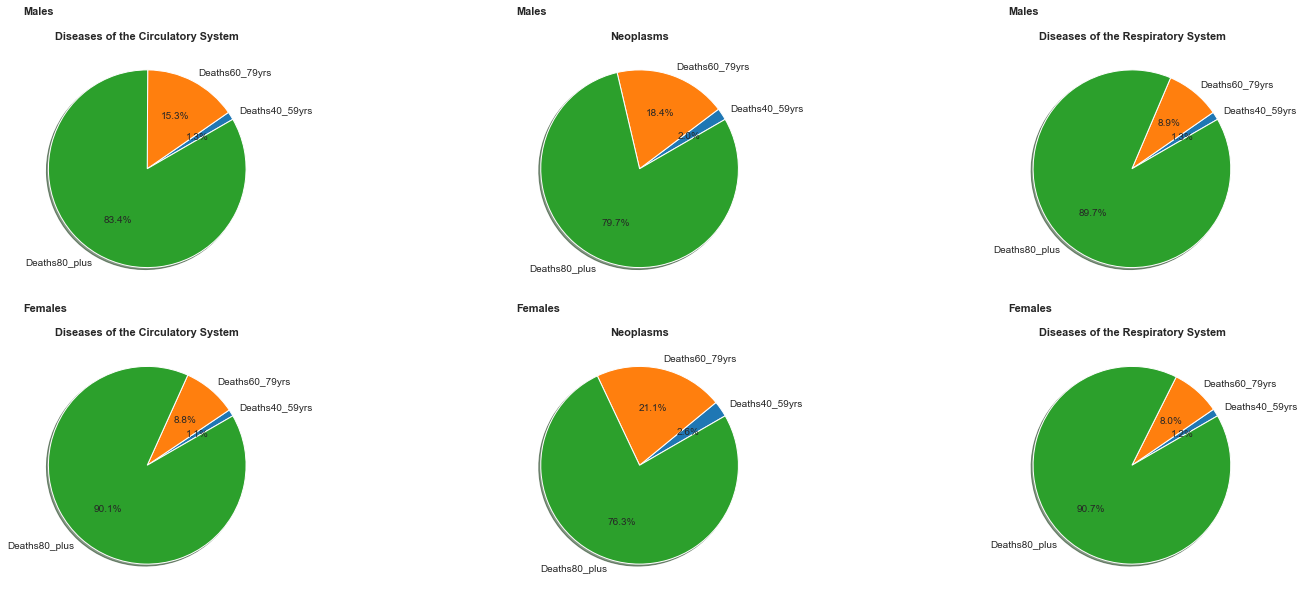

In [24]:
fig, axes = plt.subplots(2, 3, figsize=(25, 10))

for i, (idx, row) in enumerate(top_mort.set_index("ICD10").iterrows()):
    ax = axes[i // 3, i % 3]
    row = row[row.gt(row.sum() * .01)]
    ax.pie(row, labels=row.index, autopct = "%1.1f%%", startangle=30, shadow = True)
    ax.set_title(idx, fontweight = "bold", fontsize = 11)
    ax.set_title(["Males", "Females"][i // 3], loc="left", y=1.1, fontweight="bold", fontsize=11) #males top row, females bottom row
fig.subplots_adjust(wspace=.2)

The "mortality_cause_icd9" dataframe contains mortality data according to ICD9. This dataframe was initially filtered to only include information on United Kingdom in 1999. Age groupings of 20 year dividends were created from the "Deaths{num}" columns through a for loop which included a list comprehension that summed the age columns into a single group every 6 columns, apart from where there only 4 columns for infant deaths. 

Once grouped, the dataframe was further subsetted into sex-specific dataframes, sorted in descending death count to show the ICD9 codes with the highest rate of mortality by age group. The ICD code "All Causes" was dropped from the comparison as this refers to the total number of deaths from all causes, including all specific causes of death, listed in the database.

While it was expected that the "80 plus" age group would make up the predominant portion of deaths, it was interesting that in 1999, both males and females had the same top 3 highest causes of death; Diseases of the Circulatory System, Neoplasms, and Diseases of the Respiratory System. Conditions such as ischaemic heart disease (IHD), stroke, and chronic obstructive pulmonary disease (all classified within Diseases of the Circulatory System) tend to be leading causes of death every year with IHD responsible fo 16% of the world's deaths according to the WHO. Similarly, "Neoplasms" is a somewhat general term encompassing all benign and malignant abnormal cell growth in any system or part of the body. According to the WHO, lower respiratory infections are the world's most deadly communicable disease. This seems like somewhat of foreshadowing for the COVID-19 outbreak. 

Further investigation of other leading causes outside of the top 3 shows some differences between the genders. While diseases of the digestive system, the genitourinary system, and abnormal clinical findings appear with large death counts in both genders, males have a higher death count for external causes of mortality compared to women. This subgroup may include traffic accidents or accidental deaths from fires.  

One of the top causes of death in women was endocrine, metabolic, and nutritional diseases. This includes thyroid under/over activity, diabetes mellitus, or specific to women, Polycystic Ovarian Syndrome (PCOS). Endocrine disorders tend to have a higher prevalence in women. Combine this with gaps in reproductive health studies making it far more difficult for women to get diagnoses for PCOS among others, one can see just how easy it for endocrine and metabolic disorders to be a leading cause of death in women. 


## Question 3 - ICD10 Data and Timeline Plot

In [25]:
csv_files = [r"C:\Users\35387\Desktop\Python Assessment\morticd10\Morticd10_part1.csv",
            r"C:\Users\35387\Desktop\Python Assessment\morticd10\Morticd10_part2.csv",
            r"C:\Users\35387\Desktop\Python Assessment\morticd10\Morticd10_part3.csv",
            r"C:\Users\35387\Desktop\Python Assessment\morticd10\Morticd10_part4.csv",
            r"C:\Users\35387\Desktop\Python Assessment\morticd10\Morticd10_part5.csv"]

mort_list = [pd.read_csv(file, dtype = {"SubDiv": object, "List": object}) for file in csv_files] 
#DType Warnings for Columns 2 and 4
mort_icd10 = pd.concat(mort_list)
mort_icd10 = mort_icd10.rename(columns = {"Country": "Country_Num", "Deaths1": "Death_All_Ages", "Cause": "Cause_of_Death"})
mort_icd10 = mort_icd10.reset_index(drop=True)
mort_icd10 = pd.merge(country_codes, mort_icd10, how = "inner", on = "Country_Num") #add country names column to population
mort10_df = mort_icd10[mort_icd10.Country_Name.isin(uk_countries_subdivision) == False] #Drop UK Subdivisions
mort10_df_unique = mort10_df.drop_duplicates(keep = "first")
mort10_df_unique.head()


,Country_Num,Country_Name,Admin1,SubDiv,Year,List,Cause_of_Death,Sex,Frmat,IM_Frmat,...,Deaths21,Deaths22,Deaths23,Deaths24,Deaths25,Deaths26,IM_Deaths1,IM_Deaths2,IM_Deaths3,IM_Deaths4
0,1060,Cape Verde,NaN,NaN,2011,103,A05,1,2,2,...,0.0,0.0,0.0,NaN,NaN,0.0,0.0,NaN,0.0,0.0
1,1060,Cape Verde,NaN,NaN,2011,103,A09,1,2,2,...,2.0,0.0,1.0,NaN,NaN,0.0,0.0,NaN,0.0,8.0
2,1060,Cape Verde,NaN,NaN,2011,103,A09,2,2,2,...,0.0,0.0,2.0,NaN,NaN,0.0,0.0,NaN,0.0,0.0
3,1060,Cape Verde,NaN,NaN,2011,103,A15,2,2,2,...,0.0,1.0,0.0,NaN,NaN,0.0,0.0,NaN,0.0,0.0
4,1060,Cape Verde,NaN,NaN,2011,103,A16,1,2,2,...,1.0,2.0,1.0,NaN,NaN,0.0,0.0,NaN,0.0,0.0


In [28]:
#Filtering
allage_mort = mort10_df_unique[["Country_Name", "Year", "Cause_of_Death", "Sex", "Death_All_Ages"]]
#Countries that start with U
U_countries = allage_mort[lambda x:x["Country_Name"].str.contains("^U", regex = True)].copy(deep = True)
#all causes contained within the diseases of the respiratory system chapter of ICD-10
resp_mort = U_countries[lambda x: x["Cause_of_Death"].str.contains("^J", regex = True)].copy(deep = True)
other_resp = U_countries[lambda x: x["Cause_of_Death"].str.contains("107[2-7]{1}", regex = True)].copy(deep = True)
respiratory_mortality_u_countries = pd.concat([resp_mort, other_resp]).reset_index(drop = True)
print(respiratory_mortality_u_countries.Country_Name.unique()) #To ensure we have information on all relevant countries
respiratory_mortality_u_countries.head()

['United States of America' 'Uruguay' 'United Arab Emirates'
 'United Kingdom' 'Uzbekistan' 'Ukraine']


,Country_Name,Year,Cause_of_Death,Sex,Death_All_Ages
0,United States of America,1999,J00,1,1
1,United States of America,1999,J00,2,1
2,United States of America,1999,J010,2,1
3,United States of America,1999,J019,2,1
4,United States of America,1999,J020,2,2


In [29]:
print(respiratory_mortality_u_countries.Cause_of_Death.unique())

['J00' 'J010' 'J019' 'J020' 'J029' 'J030' 'J038' 'J039' 'J040' 'J041'
 'J042' 'J050' 'J051' 'J068' 'J069' 'J100' 'J101' 'J110' 'J111' 'J118'
 'J120' 'J121' 'J122' 'J128' 'J129' 'J13' 'J14' 'J150' 'J151' 'J152'
 'J153' 'J154' 'J155' 'J156' 'J157' 'J158' 'J159' 'J160' 'J168' 'J180'
 'J181' 'J182' 'J188' 'J189' 'J202' 'J208' 'J209' 'J210' 'J218' 'J219'
 'J22' 'J303' 'J304' 'J310' 'J320' 'J321' 'J322' 'J323' 'J324' 'J329'
 'J330' 'J348' 'J353' 'J359' 'J36' 'J370' 'J371' 'J380' 'J381' 'J383'
 'J384' 'J385' 'J386' 'J387' 'J390' 'J391' 'J392' 'J393' 'J398' 'J399'
 'J40' 'J411' 'J42' 'J430' 'J431' 'J432' 'J438' 'J439' 'J440' 'J441'
 'J448' 'J449' 'J450' 'J451' 'J459' 'J46' 'J47' 'J60' 'J61' 'J620' 'J628'
 'J632' 'J634' 'J64' 'J65' 'J660' 'J668' 'J670' 'J672' 'J677' 'J678'
 'J679' 'J680' 'J681' 'J683' 'J684' 'J688' 'J689' 'J690' 'J691' 'J698'
 'J700' 'J701' 'J709' 'J80' 'J81' 'J82' 'J840' 'J841' 'J848' 'J849' 'J850'
 'J851' 'J852' 'J853' 'J860' 'J869' 'J90' 'J920' 'J929' 'J930' 'J931'
 'J938' '

In [31]:
respiratory_mortality_u_countries_sum = respiratory_mortality_u_countries[["Country_Name", "Year", "Death_All_Ages"]]
respiratory_mortality_u_countries_sum = respiratory_mortality_u_countries_sum.groupby(["Country_Name", "Year"]).apply(lambda x: x["Death_All_Ages"].sum()).reset_index()
respiratory_mortality_u_countries_sum = respiratory_mortality_u_countries_sum.rename(columns = {0: "Death_All_Ages"})
print(respiratory_mortality_u_countries_sum.Year.unique())
respiratory_mortality_u_countries_sum.sort_values("Death_All_Ages", ascending = False)


[2005 2006 2007 2008 2009 2010 2011 2012 2014 2015 2017 2018 2019 2020
 2001 2002 2003 2004 2013 2016 1999 2000 1997 1998]


,Country_Name,Year,Death_All_Ages
54,United States of America,2018,282641
53,United States of America,2017,278673
51,United States of America,2015,271229
55,United States of America,2019,271026
56,United States of America,2020,270506
...,...,...,...
62,Uruguay,2002,2664
57,Uruguay,1997,2497
60,Uruguay,2000,2462
14,United Arab Emirates,2020,810


In [32]:
respmort_UAE = respiratory_mortality_u_countries_sum.loc[respiratory_mortality_u_countries_sum["Country_Name"] == "United Arab Emirates"]
respmort_UAE

,Country_Name,Year,Death_All_Ages
13,United Arab Emirates,2019,426
14,United Arab Emirates,2020,810


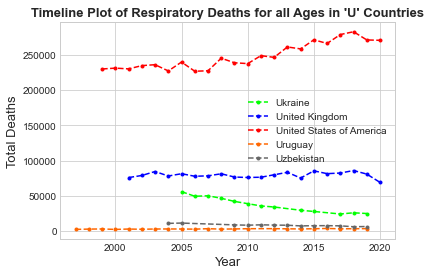

In [33]:
#United Arab Emirates was not included in the graph are there was only data from 2019 and 2020

ukr = respiratory_mortality_u_countries_sum.loc[respiratory_mortality_u_countries_sum["Country_Name"] == "Ukraine"].reset_index()
uk = respiratory_mortality_u_countries_sum.loc[respiratory_mortality_u_countries_sum["Country_Name"] == "United Kingdom"].reset_index()
usa = respiratory_mortality_u_countries_sum.loc[respiratory_mortality_u_countries_sum["Country_Name"] == "United States of America"].reset_index()
uru = respiratory_mortality_u_countries_sum.loc[respiratory_mortality_u_countries_sum["Country_Name"] == "Uruguay"].reset_index()
uzb = respiratory_mortality_u_countries_sum.loc[respiratory_mortality_u_countries_sum["Country_Name"] == "Uzbekistan"].reset_index()
year_ukr = ukr["Year"]
year_uk = uk["Year"]
year_usa = usa["Year"]
year_uru = uru["Year"]
year_uzb = uzb["Year"]
deaths_ukr = ukr["Death_All_Ages"]
deaths_uk = uk["Death_All_Ages"]
deaths_usa = usa["Death_All_Ages"]
deaths_uru = uru["Death_All_Ages"]
deaths_uzb = uzb["Death_All_Ages"]
plt.style.use("seaborn-whitegrid")
plt.plot(year_ukr, deaths_ukr, color = "#00FF00", linestyle="--", marker=".", label = "Ukraine")
plt.plot(year_uk, deaths_uk, color = "#0000FF", linestyle="--", marker=".", label = "United Kingdom")
plt.plot(year_usa, deaths_usa, color = "#FF0000", linestyle="--", marker=".", label = "United States of America")
plt.plot(year_uru, deaths_uru, color = "#FF6600", linestyle="--", marker=".", label = "Uruguay")
plt.plot(year_uzb, deaths_uzb, color = "#666666", linestyle="--", marker=".", label = "Uzbekistan")
plt.title("Timeline Plot of Respiratory Deaths for all Ages in 'U' Countries", fontweight = "bold", fontsize = 13)
plt.xlabel("Year", fontsize = 13)
plt.ylabel("Total Deaths", fontsize = 13)
plt.legend()
plt.show()

The mortality data from ICD10 were originally split into 5 parts. Each file path was stored in a list called "csv_files". The "pd.read_csv()" function was called on each file path in the list and the resulting dataframes were stored in a new list "mort_list". The "pd.concat()" function was combined all dataframes into one and the unique rows were kept after calling the "drop_duplicates" function.

To view all-age mortality from "Diseases of the Respiratory System" in countries beginning with "U",a lambda function was used to filter rows in the dataframe column "Country_Name", that start with "U". A similar method was used to obtain the respiratory disease codes from the "Cause_of_Death" column. United Arab Emirates was dropped from the resulting dataframe as there was information available from 2019 and 2020 only. The resulting line plot showed each countries total deaths over the years.

The USA saw a steady increase in deaths from respiratory diseases, peaking in 2018 with 282641 deaths. However, in the first year of the COVID-19 pandemic, 2020, deaths from respiratory diseases held steady, similar, if not lower, to previous years. Countries like the UK actually saw a decrease in respiratory deaths in 2020. This was most likely due to social distancing, strict quarantine, and masking efforts from the public. 

The remaining countries, Ukraine, Uruguay, and Uzbekhistan did not have data from respiratory deaths in 2020 therefore it was difficult to see how they were affected during the first waves of the pandemic. Ukraine saw a steady decline in respiratory deaths from the early 21st century. Changes in mortality could be concurrent with improving economic conditions and increased tobacco control policies. 


## Q4 - Country Overview Summary Table

In [34]:
mortality_cause_icd10_p5_2020 = mortality_cause_icd10_p5[mortality_cause_icd10_p5["Year"] == 2020].copy().reset_index(drop = True)
mortality_cause_icd10_p5_2020.head()

,Country_Num,Country_Name,Admin1,SubDiv,Year,List,Cause_of_Death,Sex,Frmat,IM_Frmat,...,Deaths21,Deaths22,Deaths23,Deaths24,Deaths25,Death_Unspecified_Age,IM_Deaths1,IM_Deaths2,IM_Deaths3,IM_Deaths4
0,1300,Mauritius,NaN,NaN,2020,104,AAA,1,0,1,...,584.0,511.0,332.0,214.0,79.0,0.0,8.0,39.0,35.0,44.0
1,1300,Mauritius,NaN,NaN,2020,104,AAA,2,0,1,...,579.0,672.0,528.0,385.0,187.0,0.0,10.0,22.0,24.0,18.0
2,1300,Mauritius,NaN,NaN,2020,104,A099,1,0,1,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1300,Mauritius,NaN,NaN,2020,104,A099,2,0,1,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1300,Mauritius,NaN,NaN,2020,104,A162,1,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [35]:
#1) total number of deaths from all-cause mortality for all available countries 
mort_20_allcauses = mortality_cause_icd10_p5_2020.loc[(mortality_cause_icd10_p5_2020["Cause_of_Death"] == "AAA")|\
                                                      (mortality_cause_icd10_p5_2020["Cause_of_Death"] == "1000")\
                                                     ].copy().reset_index(drop = True)
print(mort_20_allcauses.Cause_of_Death.unique())
mort_20_allcauses_sumdeaths = mort_20_allcauses.groupby("Country_Name").agg({"Death_All_Ages": "sum"}).reset_index()
mort_20_allcauses_sumdeaths.sort_values("Death_All_Ages", ascending = False).reset_index(drop = True).head(5)

['AAA' '1000']


,Country_Name,Death_All_Ages
0,United States of America,3383729
1,Mexico,1069443
2,Germany,985572
3,United Kingdom,688806
4,Spain,493776


In [36]:
mort_20_resp = mortality_cause_icd10_p5_2020[lambda x: x["Cause_of_Death"].str.contains("^J", regex = True)].copy(deep = True)
mort_20_resp2 = mortality_cause_icd10_p5_2020[lambda x: x["Cause_of_Death"].str.contains("107[2-7]{1}", regex = True)].copy(deep = True)
mort_20_resp_sum = pd.concat([mort_20_resp, mort_20_resp2])
mort_20_resp_sum = mort_20_resp_sum[["Country_Name", "Cause_of_Death", "Death_All_Ages"]]
mort_20_resp_sum = mort_20_resp_sum.groupby(["Country_Name"]).apply(lambda x: x["Death_All_Ages"].sum()).reset_index()
mort_20_resp_sum = mort_20_resp_sum.rename(columns = {0: "Resp_Deaths"})
mort_20_resp_sum.sort_values("Resp_Deaths", ascending = False).reset_index(drop = True)


,Country_Name,Resp_Deaths
0,United States of America,270506
1,Mexico,95159
2,United Kingdom,69115
3,Germany,61348
4,Spain,42423
5,Republic of Korea,36368
6,Kazakhstan,23034
7,Australia,12721
8,Ecuador,11677
9,Netherlands,10503


In [37]:
#the country population size (using the most recent value for each country)
mort_pop20 = pd.merge(country_populations_2020_sum, mortality_cause_icd10_p5_2020, how = "inner", on = "Country_Name")
mort_pop20_maxpop = mort_pop20.groupby("Country_Name").agg({"Pop_All_Ages": "max"}).reset_index()
mort_pop20_maxpop

,Country_Name,Pop_All_Ages
0,Andorra,82317
1,Australia,25687041
2,Austria,8916845
3,Czech Republic,10700155
4,Georgia,3722715
5,Germany,83160871
6,Iceland,366463
7,Israel,9215117
8,Kazakhstan,18755665
9,Latvia,1900449


In [38]:
countrymort_sumtable = pd.merge(mort_20_allcauses_sumdeaths,mort_20_resp_sum, how = "inner", on = "Country_Name")
countrymort_sumtable = countrymort_sumtable.rename(columns = {"Death_All_Ages_x": "All_Causes_Deaths", "Death_All_Ages_y": "Resp_Causes_Deaths"})
countrymort_summarytable = pd.merge(countrymort_sumtable, mort_pop20_maxpop, how = "inner", on = "Country_Name")
countrymort_sumtable.sort_values("Death_All_Ages", ascending = False)


,Country_Name,Death_All_Ages,Resp_Deaths
30,United States of America,3383729,270506
17,Mexico,1069443,95159
9,Germany,985572,61348
29,United Kingdom,688806,69115
27,Spain,493776,42423
22,Republic of Korea,304948,36368
18,Netherlands,168678,10503
13,Kazakhstan,161333,23034
1,Australia,161300,12721
5,Czech Republic,129289,8290


In [39]:
countrymort_summarytable.describe()

,Death_All_Ages,Resp_Deaths,Pop_All_Ages
count,23.000000,23.00000,2.300000e+01
mean,155293.913043,12811.26087,1.619347e+07
std,248337.651187,20100.69625,2.334466e+07
min,343.000000,48.00000,3.361500e+04
25%,16022.000000,757.50000,2.086328e+06
50%,48797.000000,4241.00000,4.602777e+06
75%,161316.500000,11612.00000,1.813387e+07
max,985572.000000,69115.00000,8.316087e+07


In [40]:
def calculate_death_rate(row):
    return (row["Resp_Deaths"] / row["Pop_All_Ages"]) * 100000
countrymort_summarytable["Death_Rate"] = countrymort_summarytable.apply(calculate_death_rate, axis=1)
countrymort_summarytable = countrymort_summarytable.sort_values("Death_Rate", ascending = False).reset_index(drop = True)
countrymort_summarytable_top10 = countrymort_summarytable.iloc[:10, :]
countrymort_summarytable_top10

,Country_Name,Death_All_Ages,Resp_Deaths,Pop_All_Ages,Death_Rate
0,San Marino,343,64,33615,190.391194
1,Kazakhstan,161333,23034,18755665,122.810895
2,Singapore,20984,4486,4044210,110.924012
3,Georgia,50537,4017,3722715,107.905118
4,United Kingdom,688806,69115,67078534,103.035943
5,Serbia,116850,6715,6899126,97.331169
6,Mauritius,11060,1206,1265740,95.280231
7,Spain,493776,42423,47355684,89.583755
8,Czech Republic,129289,8290,10700155,77.475513
9,Germany,985572,61348,83160871,73.770271


In [41]:
countrymort_summarytable_top10.describe()

,Death_All_Ages,Resp_Deaths,Pop_All_Ages,Death_Rate
count,10.000000,10.00000,1.000000e+01,10.000000
mean,265855.000000,22069.80000,2.430163e+07,106.850810
std,340317.900977,26143.85425,3.036411e+07,32.907039
min,343.000000,64.00000,3.361500e+04,73.770271
25%,28372.250000,4134.25000,3.803089e+06,91.007874
50%,123069.500000,7502.50000,8.799640e+06,100.183556
75%,410665.250000,37575.75000,4.020568e+07,110.169289
max,985572.000000,69115.00000,8.316087e+07,190.391194


To access the total number of deaths from all-cause mortality, the "mortality_cause_icd10_p5_2020" dataframe was filtered for rows where the "Cause_of_Death" column was equal to "AAA" or "1000", the detailed codes from "All Causes", then grouped by country get each total death count.

To find the number of respiratory deaths per country, a lambda function was used to return rows where the "Cause_of_Death" column contained a string starting with "J", or a string from 1072 to 1077, the codes allocated to respiratory deaths in the ICD10 code list. 

From here, the max population for each country was found by grouping the dataframe by country and applying the agg method to compute the maxmium population value from the "Pop_All_Ages" column. This results in a unique row for each country. 

Finally, to calculate the death rate, the WHO method of dividing the deaths by the population and multiplying by 100,000 (to get the death rate per 100,000 people) was used to define a function "calculate_death_rate" which takes a row of data as the arguement and returns the death rate of that row. This was applied to the country mortality summary table with an "axis = 1" arguement, specifying the function is applied across the rows. 

The resulting table shows the 10 highest death rates. Very small countries, such as San Marino, should be considered outliers as their death count is far below the mean death total of 265855 as seen from the descriptive table. Conversely, countries such as Germany with very high populations and thus, higher deaths and death rates, are outliers on the other end of the scale. Furthermore, countries with lower death rates such as Germany and also Spain have notably strong healthcare systems which should contribute to lower death counts and subsequent death rates. On the other hand, developing countries such as Kazakhstan with more basic quality of healthcare and healthcare infrastructure suffers from a larger death rate than average. 

Several countries circle close to the mean death rate, particularly the United Kingdom. To further this investigation, it would be interesting to have the WHO data on life expectancy and health life expectancy to give further context to these death rates. 


## Question 5 - Function

In [42]:
def get_mortality_data(icd10_code, country, start_year, end_year, mort10):
    # Filter the data by the specified ICD-10 code, country, and range of years
    mort10_filtered = mort10_df_unique[(mort10_df_unique["Cause_of_Death"] == icd10_code) & (mort10_df_unique["Country_Name"] == country) & \
                                       (mort10_df_unique["Year"] >= start_year) & (mort10_df_unique["Year"] <= end_year)\
                                      ].reset_index(drop = True)
    
    return mort10_filtered

    
# Test the function for mortality caused by the ICD-10 code J180 (Pneumonia), for each year between 2010-2020 only for the United Kingdom and France.
df_uk = get_mortality_data("J180", "United Kingdom", 2010, 2020, mort10_df_unique)
df_france = get_mortality_data('J180', 'France', 2010, 2020, mort10_df_unique)

In [43]:
df_uk #22 rows 

,Country_Num,Country_Name,Admin1,SubDiv,Year,List,Cause_of_Death,Sex,Frmat,IM_Frmat,...,Deaths21,Deaths22,Deaths23,Deaths24,Deaths25,Deaths26,IM_Deaths1,IM_Deaths2,IM_Deaths3,IM_Deaths4
0,4308,United Kingdom,NaN,NaN,2010,104,J180,1,0,1,...,575.0,986.0,1341.0,1021.0,585.0,0.0,0.0,0.0,1.0,5.0
1,4308,United Kingdom,NaN,NaN,2010,104,J180,2,0,1,...,569.0,1225.0,2145.0,2241.0,1979.0,0.0,0.0,0.0,0.0,3.0
2,4308,United Kingdom,NaN,NaN,2011,104,J180,1,0,1,...,520.0,997.0,1342.0,1153.0,554.0,0.0,0.0,0.0,0.0,7.0
3,4308,United Kingdom,NaN,NaN,2011,104,J180,2,0,1,...,503.0,1129.0,2092.0,2318.0,1926.0,0.0,0.0,0.0,0.0,1.0
4,4308,United Kingdom,NaN,NaN,2012,104,J180,1,0,1,...,568.0,950.0,1357.0,1265.0,633.0,0.0,0.0,0.0,0.0,7.0
5,4308,United Kingdom,NaN,NaN,2012,104,J180,2,0,1,...,498.0,1152.0,1955.0,2493.0,1898.0,0.0,0.0,0.0,0.0,5.0
6,4308,United Kingdom,NaN,NaN,2013,104,J180,1,0,1,...,556.0,965.0,1239.0,1260.0,585.0,0.0,0.0,0.0,0.0,9.0
7,4308,United Kingdom,NaN,NaN,2013,104,J180,2,0,1,...,509.0,1041.0,1887.0,2432.0,1838.0,0.0,0.0,0.0,0.0,4.0
8,4308,United Kingdom,NaN,NaN,2014,104,J180,1,0,1,...,518.0,854.0,1168.0,1140.0,501.0,0.0,0.0,0.0,0.0,0.0
9,4308,United Kingdom,NaN,NaN,2014,104,J180,2,0,1,...,447.0,962.0,1573.0,2090.0,1468.0,0.0,0.0,0.0,0.0,3.0


In [44]:
df_france #16 rows 

,Country_Num,Country_Name,Admin1,SubDiv,Year,List,Cause_of_Death,Sex,Frmat,IM_Frmat,...,Deaths21,Deaths22,Deaths23,Deaths24,Deaths25,Deaths26,IM_Deaths1,IM_Deaths2,IM_Deaths3,IM_Deaths4
0,4080,France,NaN,NaN,2010,104,J180,1,0,1,...,68.0,149.0,223.0,115.0,85.0,0.0,0.0,0.0,0.0,2.0
1,4080,France,NaN,NaN,2010,104,J180,2,0,1,...,52.0,137.0,296.0,208.0,309.0,0.0,0.0,0.0,0.0,0.0
2,4080,France,NaN,NaN,2011,104,J180,1,0,1,...,64.0,130.0,193.0,149.0,71.0,0.0,0.0,0.0,0.0,0.0
3,4080,France,NaN,NaN,2011,104,J180,2,0,1,...,50.0,112.0,196.0,218.0,243.0,0.0,0.0,0.0,0.0,0.0
4,4080,France,NaN,NaN,2012,104,J180,1,0,1,...,65.0,142.0,232.0,185.0,96.0,0.0,0.0,0.0,0.0,0.0
5,4080,France,NaN,NaN,2012,104,J180,2,0,1,...,45.0,114.0,304.0,343.0,279.0,0.0,0.0,0.0,0.0,0.0
6,4080,France,NaN,NaN,2013,104,J180,1,0,1,...,54.0,107.0,183.0,208.0,78.0,0.0,0.0,0.0,0.0,0.0
7,4080,France,NaN,NaN,2013,104,J180,2,0,1,...,34.0,114.0,237.0,324.0,219.0,0.0,0.0,0.0,0.0,0.0
8,4080,France,NaN,NaN,2014,104,J180,1,0,1,...,53.0,113.0,167.0,171.0,79.0,0.0,0.0,0.0,0.0,0.0
9,4080,France,NaN,NaN,2014,104,J180,2,0,1,...,36.0,87.0,215.0,302.0,195.0,0.0,0.0,0.0,0.0,0.0


The function "get_mortality_data" takes five arguments:

        icd10_code: string specifying the ICD-10 code for cause of death
        country: string specifying country
        start_year: integer specifying the start year of the time range
        end_year: integer specifying the end year of the time range
        mort10: datframe of ICD10 mortality data
        
The function filters the rows of the mort10 data frame to include only those that match the specified ICD-10 code, country, and time range, and then returns the resulting data frame (mort10_filtered).

To test this code, the data surrounding mortality from pneumonia (ICD10 code J180) in UK and France from 2011-2020 was pulled. The resulting outputs had sex specific death counts for each year. This produced 22 rows of data on the UK and 16 rows of data on France. 


## Question 6 - COVID-19 Scatter Plot

In [84]:
covid2020_mortality = mort10_df.loc[(mort10_df["Year"] == 2020) & (mort10_df["Cause_of_Death"] == "U071")].reset_index(drop = True)
covid2020_mortality_sum = covid2020_mortality.groupby(["Country_Name"]).apply(lambda x: x["Death_All_Ages"].sum()).reset_index()
covid2020_mortality_sum = covid2020_mortality_sum.rename(columns = {0: "Total_Covid_Deaths"})
covid2020_mortality_sum.sort_values("Total_Covid_Deaths", ascending = False)



,Country_Name,Total_Covid_Deaths
22,United States of America,350831
15,Mexico,146834
21,United Kingdom,75838
19,Spain,60358
7,Germany,38510
16,Netherlands,17495
4,Ecuador,15490
3,Czech Republic,10366
8,Guatemala,7428
1,Austria,6224


In [46]:
country_populations_df #Find the most recent population figure (i.e. the population for the max year)
grouped_pop = country_populations_df.groupby("Country_Name")
pop_max = grouped_pop["Year"].apply(max)
countrypop_max = country_populations_df.merge(pop_max, on = ["Country_Name", "Year"])
#add the two populations (ie for both sexes) for each country
countrypop_max = countrypop_max.groupby("Country_Name").agg({"Pop_All_Ages":"sum"}).reset_index()
countrypop_max

,Country_Name,Pop_All_Ages
0,Albania,2889173.0
1,Andorra,82317.5
2,Antigua and Barbuda,78000.0
3,Argentina,35219400.0
4,Armenia,2962482.0
...,...,...
144,Uruguay,3094000.0
145,Uzbekistan,33580390.0
146,Venezuela,21378200.0
147,Virgin Islands (USA),116000.0


In [47]:
covid2020_mort_pop = covid2020_mortality_sum.merge(countrypop_max, how = "inner", on = "Country_Name")
covid2020_mort_pop


,Country_Name,Total_Covid_Deaths,Pop_All_Ages
0,Australia,882,2.568704e+07
1,Austria,6224,8.916845e+06
2,Costa Rica,2276,5.058007e+06
3,Czech Republic,10366,1.070016e+07
4,Ecuador,15490,1.050170e+07
5,Estonia,201,1.315790e+06
6,Georgia,2587,3.722716e+06
7,Germany,38510,8.316087e+07
8,Guatemala,7428,7.740000e+06
9,Iceland,28,3.664630e+05


In [48]:
who_additional_info_nonull.head()
WHO_country_additional_info = who_additional_info_nonull[["Country_Name", "region_name", "size_sq_km", "che_gdp", "che_pc_usd", "gdp_pc_usd", "economic_data_year"]]
WHO_country_additional_info.head() #info for scatter plot


,Country_Name,region_name,size_sq_km,che_gdp,che_pc_usd,gdp_pc_usd,economic_data_year
0,Algeria,African Region,2381741.0,6.3,215,"3,398.9",2020.0
1,Angola,African Region,1246700.0,2.9,51,"1,742.6",2020.0
2,Benin,African Region,112760.0,2.6,32,"1,240.7",2020.0
3,Botswana,African Region,566730.0,6.2,363,"5,863.2",2020.0
4,Burkina Faso,African Region,273600.0,6.7,54,806.3,2020.0


In [49]:
covid_country_additional_info = pd.merge(covid2020_mort_pop, WHO_country_additional_info, how = "inner", on = "Country_Name")
covid_country_additional_info.sort_values("Total_Covid_Deaths", ascending = False).reset_index(drop = True)


,Country_Name,Total_Covid_Deaths,Pop_All_Ages,region_name,size_sq_km,che_gdp,che_pc_usd,gdp_pc_usd,economic_data_year
0,United States of America,350831,3.015799e+08,Region of the Americas,9147420.000,18.8,"11,702","62,194.5",2020.0
1,Mexico,146834,9.114520e+07,Region of the Americas,1943950.000,6.2,539,"8,628.0",2020.0
2,United Kingdom,75838,6.707853e+07,European Region,241930.000,11.9,"5,634","47,191.1",2021.0
3,Spain,60358,4.735568e+07,European Region,499556.645,10.7,"2,901","27,074.0",2020.0
4,Germany,38510,8.316087e+07,European Region,349390.000,12.8,"6,503","50,786.1",2021.0
5,Netherlands,17495,1.751208e+07,European Region,33670.000,11.2,"6,531","58,253.7",2021.0
6,Ecuador,15490,1.050170e+07,Region of the Americas,248360.000,8.5,479,"5,645.2",2020.0
7,Czech Republic,10366,1.070016e+07,European Region,77198.530,9.2,"2,120","22,941.9",2020.0
8,Guatemala,7428,7.740000e+06,Region of the Americas,107160.000,6.5,289,"4,469.6",2020.0
9,Austria,6224,8.916845e+06,European Region,82520.000,12.2,"6,491","53,321.4",2021.0


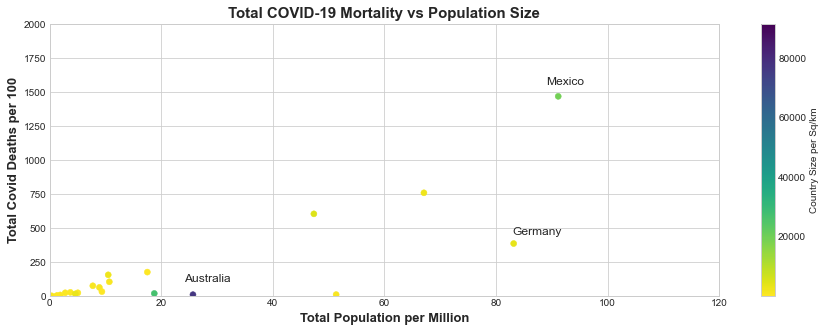

In [50]:
plt.figure(figsize = (15,5))
x = (covid_country_additional_info["Pop_All_Ages"]/1000000).astype(float)
y = (covid_country_additional_info["Total_Covid_Deaths"]/100).astype(float)
mycolour = (covid_country_additional_info["size_sq_km"]/100).astype(float)
mysizes = covid_country_additional_info["che_gdp"]
plt.scatter(x, y, c = mycolour, cmap = "viridis_r", linewidth = 0.5)
cbar =  plt.colorbar()
cbar.set_label("Country Size per Sq/km")
plt.ylabel("Total Covid Deaths per 100", fontweight = "bold", fontsize = 13)
plt.xlabel("Total Population per Million", fontweight = "bold", fontsize = 13)
plt.annotate("Mexico", xy = (85,1500), xytext = (89, 1550), fontsize = 12)
plt.annotate("Germany", xy = (85, 250), xytext = (83, 450), fontsize = 12)
plt.annotate("Australia", xy = (25,10), xytext = (24, 100), fontsize = 12)
plt.xlim(0,120)
plt.ylim(0,2000)
plt.title("Total COVID-19 Mortality vs Population Size", fontweight = "bold", fontsize = 15)
plt.show()



This portion looked at COVID-19 mortality in 2020 versus population size (most recent figure). 

To start, the "country_populations_df" was grouped by "Country_Name" and the most recent population figure was found by finding the maximum "Year" value for each country using the "apply()" method. This was merged back with the original dataframe to reobtain the population data. The total population per country was found by summing the values of "Pop_All_Ages" per country using the "agg" function. This resulting dataframe was merged with "covid2020_mortality_sum" to give information on covid deaths per country. Additional information on country sizes, current health expenditure as a percentage of gross domestic product (CHE_GDP) and economic year were added by merging with the dataframe "WHO_country_additional_info". 

The resulting scatterplot looked at the total COVID-19 deaths (per 100) by population (per million). USA created quite a disproportionate graph as a very large country (9147420/km^2) with incredibly high COVID-19 death numbers (n=350831) in one year. For the sake of visualisation, the x and y axes were limited so USA was removed and the other countries could be seen more clearly. 

Countries with relatively similar population sizes such as Mexico (n=9.114520e+07) and Germany (n=8.316087e+07) had very different total COVID-19 death tolls with Mexicos numbers almost four times higher than Germanys. In terms of CHE-GDP, Germany channels over twice the resources (12.8 vs 6.2) into the healthcare sector compared to Mexico. As Germany gives more priority the health sector in the economy, this could explain why their death numbers were significantly lower. 

While Australia is significantly larger (7692020/km^2) than other countries on the graph, the country benefitted from also having a high CHE-GDP as well as having a lot of desert land resulting in a lower population than expected for this size of country. Thus, the number of COVID-19 deaths in the max population year was significantly lower than countries of similar sizes. 

## Question 7 - Bar Chart of Mortality

In [83]:
top_covid_mort = covid2020_mortality.sort_values("Death_All_Ages", ascending = False).reset_index(drop = True)
top_covid_mort = top_covid_mort.head(20)
top_covid_mort.sort_values("Death_All_Ages")

,Country_Num,Country_Name,Admin1,SubDiv,Year,List,Cause_of_Death,Sex,Frmat,IM_Frmat,...,Deaths21,Deaths22,Deaths23,Deaths24,Deaths25,Deaths26,IM_Deaths1,IM_Deaths2,IM_Deaths3,IM_Deaths4
19,2250,Guatemala,NaN,NaN,2020,104,U071,2,0,1,...,191.0,153.0,86.0,34.0,11.0,5.0,2.0,0.0,2.0,6.0
18,4010,Austria,NaN,NaN,2020,104,U071,2,0,1,...,307.0,519.0,712.0,672.0,346.0,0.0,0.0,0.0,0.0,0.0
17,4010,Austria,NaN,NaN,2020,104,U071,1,0,1,...,543.0,750.0,639.0,437.0,119.0,0.0,0.0,0.0,0.0,0.0
16,4045,Czech Republic,NaN,NaN,2020,104,U071,2,0,1,...,752.0,892.0,1006.0,644.0,213.0,0.0,0.0,0.0,0.0,0.0
15,2180,Ecuador,NaN,NaN,2020,104,U071,2,0,8,...,681.0,562.0,444.0,235.0,95.0,0.0,9.0,NaN,NaN,NaN
14,2250,Guatemala,NaN,NaN,2020,104,U071,1,0,1,...,454.0,309.0,173.0,71.0,7.0,17.0,6.0,2.0,2.0,9.0
13,4045,Czech Republic,NaN,NaN,2020,104,U071,1,0,1,...,1207.0,1108.0,870.0,395.0,94.0,0.0,0.0,0.0,0.0,0.0
12,4210,Netherlands,NaN,NaN,2020,104,U071,2,0,1,...,938.0,1471.0,2013.0,1675.0,813.0,0.0,0.0,0.0,0.0,0.0
11,4210,Netherlands,NaN,NaN,2020,104,U071,1,0,1,...,1678.0,2065.0,2073.0,1124.0,297.0,0.0,0.0,0.0,0.0,1.0
10,2180,Ecuador,NaN,NaN,2020,104,U071,1,0,8,...,1206.0,987.0,712.0,296.0,91.0,2.0,11.0,NaN,NaN,NaN


In [52]:
other_mort = mortality_cause_icd10_p5_2020[mortality_cause_icd10_p5_2020["Country_Name"].isin(top_covid_mort["Country_Name"])]
other_mort = other_mort.loc[other_mort["Cause_of_Death"] != "AAA"]
#top 10 deaths including COVId 19 
top_mort = other_mort.groupby(["Cause_of_Death"]).agg({"Death_All_Ages": "sum"}).reset_index()
top_mort5 = top_mort.sort_values("Death_All_Ages", ascending = False).head(5)
top_mort5

,Cause_of_Death,Death_All_Ages
4269,U071,729370
2002,I219,354622
2007,I251,258128
565,C349,252119
1472,F03,217999


In [53]:
other_mort
mortality_causes_top5 = ["U071", "I219", "I251", "C349", "F03"]
other_mort = other_mort[other_mort["Cause_of_Death"].isin(mortality_causes_top5)]
other_mort
#other_mort = other_mort.loc[["U071", "I219", "I251", "C349", "F03"]]
#U071 = Covid, I219 = "Acute Myocardial Infarction", I251 = "Atherosclerotic Disease", C349 = "Malignant Neoplasm, Bronchus or Lung", F03 = "Unspecified Dementia"

,Country_Num,Country_Name,Admin1,SubDiv,Year,List,Cause_of_Death,Sex,Frmat,IM_Frmat,...,Deaths21,Deaths22,Deaths23,Deaths24,Deaths25,Death_Unspecified_Age,IM_Deaths1,IM_Deaths2,IM_Deaths3,IM_Deaths4
3165,2180,Ecuador,NaN,NaN,2020,104,C349,1,0,8,...,57.0,50.0,49.0,9.0,8.0,0.0,0.0,NaN,NaN,NaN
3166,2180,Ecuador,NaN,NaN,2020,104,C349,2,0,8,...,44.0,40.0,27.0,21.0,5.0,0.0,0.0,NaN,NaN,NaN
3868,2180,Ecuador,NaN,NaN,2020,104,F03,1,0,8,...,2.0,11.0,11.0,19.0,11.0,0.0,0.0,NaN,NaN,NaN
3869,2180,Ecuador,NaN,NaN,2020,104,F03,2,0,8,...,3.0,9.0,8.0,19.0,13.0,0.0,0.0,NaN,NaN,NaN
4121,2180,Ecuador,NaN,NaN,2020,104,I219,1,0,8,...,1073.0,1137.0,1070.0,830.0,426.0,0.0,1.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69386,4308,United Kingdom,NaN,NaN,2020,104,C349,2,0,1,...,2945.0,2440.0,1549.0,761.0,196.0,0.0,0.0,0.0,0.0,0.0
69826,4308,United Kingdom,NaN,NaN,2020,104,F03,2,0,1,...,1521.0,3596.0,6368.0,7001.0,4463.0,0.0,0.0,0.0,0.0,0.0
70037,4308,United Kingdom,NaN,NaN,2020,104,I219,2,0,1,...,1297.0,1560.0,1676.0,1191.0,532.0,0.0,0.0,0.0,0.0,0.0
70041,4308,United Kingdom,NaN,NaN,2020,104,I251,2,0,1,...,578.0,596.0,532.0,270.0,108.0,0.0,0.0,0.0,0.0,0.0


In [54]:
other_mort = other_mort.replace({"Cause_of_Death": {"U071": "COVID", "I219": \
                                                    "Acute Myocardial Infarction", \
                                                    "I251": "Atherosclerotic Disease", \
                                                    "C349": "Malignant Neoplasm, Bronchus or Lung", \
                                                   "F03": "Unspecified Dementia"}})
other_mort

,Country_Num,Country_Name,Admin1,SubDiv,Year,List,Cause_of_Death,Sex,Frmat,IM_Frmat,...,Deaths21,Deaths22,Deaths23,Deaths24,Deaths25,Death_Unspecified_Age,IM_Deaths1,IM_Deaths2,IM_Deaths3,IM_Deaths4
3165,2180,Ecuador,NaN,NaN,2020,104,"Malignant Neoplasm, Bronchus or Lung",1,0,8,...,57.0,50.0,49.0,9.0,8.0,0.0,0.0,NaN,NaN,NaN
3166,2180,Ecuador,NaN,NaN,2020,104,"Malignant Neoplasm, Bronchus or Lung",2,0,8,...,44.0,40.0,27.0,21.0,5.0,0.0,0.0,NaN,NaN,NaN
3868,2180,Ecuador,NaN,NaN,2020,104,Unspecified Dementia,1,0,8,...,2.0,11.0,11.0,19.0,11.0,0.0,0.0,NaN,NaN,NaN
3869,2180,Ecuador,NaN,NaN,2020,104,Unspecified Dementia,2,0,8,...,3.0,9.0,8.0,19.0,13.0,0.0,0.0,NaN,NaN,NaN
4121,2180,Ecuador,NaN,NaN,2020,104,Acute Myocardial Infarction,1,0,8,...,1073.0,1137.0,1070.0,830.0,426.0,0.0,1.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69386,4308,United Kingdom,NaN,NaN,2020,104,"Malignant Neoplasm, Bronchus or Lung",2,0,1,...,2945.0,2440.0,1549.0,761.0,196.0,0.0,0.0,0.0,0.0,0.0
69826,4308,United Kingdom,NaN,NaN,2020,104,Unspecified Dementia,2,0,1,...,1521.0,3596.0,6368.0,7001.0,4463.0,0.0,0.0,0.0,0.0,0.0
70037,4308,United Kingdom,NaN,NaN,2020,104,Acute Myocardial Infarction,2,0,1,...,1297.0,1560.0,1676.0,1191.0,532.0,0.0,0.0,0.0,0.0,0.0
70041,4308,United Kingdom,NaN,NaN,2020,104,Atherosclerotic Disease,2,0,1,...,578.0,596.0,532.0,270.0,108.0,0.0,0.0,0.0,0.0,0.0


In [55]:
other_mort.reset_index()

,index,Country_Num,Country_Name,Admin1,SubDiv,Year,List,Cause_of_Death,Sex,Frmat,...,Deaths21,Deaths22,Deaths23,Deaths24,Deaths25,Death_Unspecified_Age,IM_Deaths1,IM_Deaths2,IM_Deaths3,IM_Deaths4
0,3165,2180,Ecuador,NaN,NaN,2020,104,"Malignant Neoplasm, Bronchus or Lung",1,0,...,57.0,50.0,49.0,9.0,8.0,0.0,0.0,NaN,NaN,NaN
1,3166,2180,Ecuador,NaN,NaN,2020,104,"Malignant Neoplasm, Bronchus or Lung",2,0,...,44.0,40.0,27.0,21.0,5.0,0.0,0.0,NaN,NaN,NaN
2,3868,2180,Ecuador,NaN,NaN,2020,104,Unspecified Dementia,1,0,...,2.0,11.0,11.0,19.0,11.0,0.0,0.0,NaN,NaN,NaN
3,3869,2180,Ecuador,NaN,NaN,2020,104,Unspecified Dementia,2,0,...,3.0,9.0,8.0,19.0,13.0,0.0,0.0,NaN,NaN,NaN
4,4121,2180,Ecuador,NaN,NaN,2020,104,Acute Myocardial Infarction,1,0,...,1073.0,1137.0,1070.0,830.0,426.0,0.0,1.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,69386,4308,United Kingdom,NaN,NaN,2020,104,"Malignant Neoplasm, Bronchus or Lung",2,0,...,2945.0,2440.0,1549.0,761.0,196.0,0.0,0.0,0.0,0.0,0.0
96,69826,4308,United Kingdom,NaN,NaN,2020,104,Unspecified Dementia,2,0,...,1521.0,3596.0,6368.0,7001.0,4463.0,0.0,0.0,0.0,0.0,0.0
97,70037,4308,United Kingdom,NaN,NaN,2020,104,Acute Myocardial Infarction,2,0,...,1297.0,1560.0,1676.0,1191.0,532.0,0.0,0.0,0.0,0.0,0.0
98,70041,4308,United Kingdom,NaN,NaN,2020,104,Atherosclerotic Disease,2,0,...,578.0,596.0,532.0,270.0,108.0,0.0,0.0,0.0,0.0,0.0


In [88]:
other_mort2 = other_mort.groupby(["Country_Name", "Cause_of_Death"]).agg({"Death_All_Ages": "sum"}).reset_index()
other_mort2


,Country_Name,Cause_of_Death,Death_All_Ages
0,Austria,Acute Myocardial Infarction,3657
1,Austria,Atherosclerotic Disease,6125
2,Austria,COVID,6224
3,Austria,"Malignant Neoplasm, Bronchus or Lung",3582
4,Austria,Unspecified Dementia,2282
5,Czech Republic,Acute Myocardial Infarction,1817
6,Czech Republic,Atherosclerotic Disease,2313
7,Czech Republic,COVID,10366
8,Czech Republic,"Malignant Neoplasm, Bronchus or Lung",2391
9,Czech Republic,Unspecified Dementia,395


In [89]:
other_mort3 = other_mort2.iloc[:45, :]
other_mort3

,Country_Name,Cause_of_Death,Death_All_Ages
0,Austria,Acute Myocardial Infarction,3657
1,Austria,Atherosclerotic Disease,6125
2,Austria,COVID,6224
3,Austria,"Malignant Neoplasm, Bronchus or Lung",3582
4,Austria,Unspecified Dementia,2282
5,Czech Republic,Acute Myocardial Infarction,1817
6,Czech Republic,Atherosclerotic Disease,2313
7,Czech Republic,COVID,10366
8,Czech Republic,"Malignant Neoplasm, Bronchus or Lung",2391
9,Czech Republic,Unspecified Dementia,395


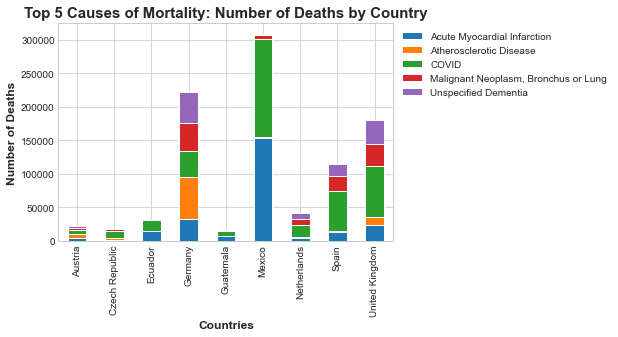

In [90]:
pivot_data = other_mort3.pivot(index = "Country_Name", columns = "Cause_of_Death", values = "Death_All_Ages")
pivot_data.plot(kind = "bar", stacked = True)
plt.ylabel("Number of Deaths", fontsize = 12, fontweight = "bold")
plt.xlabel("Countries", fontsize = 12, fontweight = "bold")
plt.title("Top 5 Causes of Mortality: Number of Deaths by Country", fontsize = 15, fontweight = "bold")
plt.legend(bbox_to_anchor=(1.0, 1.0))


The top 10 countries with the highest rate of mortality from COVID-19 were found by filtering the mortality ICD data to only causes of death from covid (code "U071"), sorting by death count, and subsetting for the top 20 rows (as the dataframe is sex-specific). The top 10 countries were USA, Mexico, UK, Spain, Germany, Netrherlands, Ecuador, Czech Republic, Guatemala, and Austria. A new dataframe was created which contained the causes of death from these listed countries using the "isin()" method. The top 5 causes of death (including COVID-19) of this new dataframe were found and used to display the leading causes of mortality in these countries. 

As USA has a significantly larger death numbers than the other countries, the country was removed from the graph to allow for more proportionate viewing of the causes of death and subsequent death numbers. Information on USA can be found in the dataframe above, "other_mort2".

After COVID-19, acute myocardial infarctions were the second most common cause of mortality in these countries (n=354622) with particular prevalence seen in Mexico. In addition, malignant neoplasms of the bronchus and lungs were seen in significant numbers in Germany and UK. These countries both have very high populations and busy cities with a lot of air pollution which could contribute to this higher prevalence. 

Finally, low fertility and increasing life expectancies have lead to older populations in many countries, particularly in first world countries such as Germany, Spain, and UK. This could, in part, explain unspecified dementia being a lead cause of mortality notably present in these three countries compared to the other seven.



## Question 8 - Object Oriented Programming 

In [143]:
covid2020_mortality.head()
covid2020_oop = covid2020_mortality[["Country_Name", "Sex", "Death_All_Ages"]]
covid2020_oop.head()

,Country_Name,Sex,Death_All_Ages
0,Mauritius,1,9
1,Mauritius,2,1
2,Costa Rica,1,1438
3,Costa Rica,2,838
4,Ecuador,1,10234


In [145]:
who_additional_info_nonull.head()
covid2020_oop_info = pd.merge(covid2020_oop, who_additional_info_nonull, how = "outer", on = "Country_Name")
covid2020_oop_info = covid2020_oop_info[["Country_Name", "Sex", "Death_All_Ages", "region", "region_name"]]
covid2020_oop_info = covid2020_oop_info.rename(columns = {"Death_All_Ages": "COVID_Deaths"})
covid2020_oop_info.sort_values("COVID_Deaths", ascending = False).head()

,Country_Name,Sex,COVID_Deaths,region,region_name
11,United States of America,1.0,192512.0,AMR,Region of the Americas
12,United States of America,2.0,158319.0,AMR,Region of the Americas
8,Mexico,1.0,93698.0,AMR,Region of the Americas
9,Mexico,2.0,53132.0,AMR,Region of the Americas
43,United Kingdom,1.0,42277.0,EUR,European Region


In [141]:
class Country:
    def __init__(self, name, region):
        self.name = name
        self.region = region
        self.mortality_data = {}
        self.countries = []
    
    def add_mortality_data(self, sex, deaths):
        if sex not in self.mortality_data:
            self.mortality_data[sex] = deaths
        else:
            self.mortality_data[sex] += deaths
    
    def get_total_deaths(self):
        total_deaths = 0
        for deaths in self.mortality_data.values():
            total_deaths += deaths
        return total_deaths
    
    def get_deaths_by_sex(self, sex):
        if sex in self.mortality_data:
            return self.mortality_data[sex]
        else:
            return 0
    
    def add_country(self, country):
        self.countries.append(country)

#Dictionary for Country objects
countries = {}


for index, row in covid2020_oop_info.iterrows():
    # Get the country name and sex-specific mortality data for the current row
    country_name = row["Country_Name"]
    sex = float(row["Sex"])
    deaths = row["COVID_Deaths"]
    
    # Check if a Country object for the current country already exists
    # If it does not exist, create a new Country object and add it to the dictionary
    if country_name not in countries:
        countries[country_name] = Country(country_name, row["region_name"])
    
    # Get the Country object for the current country
    country = countries[country_name]
    
    # Add the sex-specific mortality data for the current row to the Country object
    country.add_mortality_data(sex, deaths)

for country in countries.values():
    print(f'Country: {country.name}')
    
    for sex, deaths in country.mortality_data.items():
        print(f'  {sex}: {deaths}')
    
    print(f'  Total: {country.get_total_deaths()}')



Country: Mauritius
  1.0: 9.0
  2.0: 1.0
  Total: 10.0
Country: Costa Rica
  1.0: 1438.0
  2.0: 838.0
  Total: 2276.0
Country: Ecuador
  1.0: 10234.0
  2.0: 5256.0
  Total: 15490.0
Country: Guatemala
  1.0: 5298.0
  2.0: 2130.0
  Total: 7428.0
Country: Mexico
  1.0: 93698.0
  2.0: 53132.0
  9.0: 4.0
  Total: 146834.0
Country: United States of America
  1.0: 192512.0
  2.0: 158319.0
  Total: 350831.0
Country: Israel
  1.0: 1818.0
  2.0: 1331.0
  Total: 3149.0
Country: Oman
  1.0: 1048.0
  2.0: 405.0
  Total: 1453.0
Country: Republic of Korea
  1.0: 480.0
  2.0: 466.0
  Total: 946.0
Country: United Arab Emirates
  1.0: 546.0
  2.0: 111.0
  Total: 657.0
Country: Austria
  1.0: 3293.0
  2.0: 2931.0
  Total: 6224.0
Country: Czech Republic
  1.0: 5852.0
  2.0: 4514.0
  Total: 10366.0
Country: Estonia
  1.0: 95.0
  2.0: 106.0
  Total: 201.0
Country: Georgia
  1.0: 1458.0
  2.0: 1129.0
  Total: 2587.0
Country: Germany
  1.0: 20247.0
  2.0: 18263.0
  Total: 38510.0
Country: Iceland
  1.0: 14.0


In [155]:
class Region:
    def __init__(self, covid2020_oop_info):
        self.covid2020_oop_info = covid2020_oop_info
    
    def total_deaths_by_country(self):
        return self.covid2020_oop_info.groupby("Country_Name")["COVID_Deaths"].sum()
    
regions = Region(covid2020_oop_info)
deaths_by_country = regions.total_deaths_by_country()

In [150]:
class World:
    def __init__(self, covid2020_oop_info):
        self.covid2020_oop_info = covid2020_oop_info
    
    def total_deaths_by_region(self):
        return self.covid2020_oop_info.groupby("region_name")["COVID_Deaths"].sum()
    
    def total_deaths(self):
        return self.covid2020_oop_info["COVID_Deaths"].sum()

world = World(covid2020_oop_info)
total_deaths_by_region = world.total_deaths_by_region()
total_deaths = world.total_deaths()
print(total_deaths_by_region)
print("Total number of COVID-19 deaths: " + str(total_deaths))

region_name
African Region                      10.0
Eastern Mediterranean Region      2110.0
European Region                 219498.0
Region of the Americas          522859.0
South-East Asian Region              0.0
Western Pacific Region            1828.0
Name: COVID_Deaths, dtype: float64
Total number of COVID-19 deaths: 746305.0


The COVID-19 deaths from across the world specific to country or region were modelled by building three classes. 

The Country Class gave sex-specific and total death counts from COVID-19 per country by methods "add_mortality_data", "get_total_deaths" and "get_deaths_by_sex". These were used to add sex-specific mortality data from each row to the Country object with total_deaths being the sum of the two values. This resulted in an output similar to what was seen in the "covid2020_oop_info" dataframe, with the USA having the highest amount of COVID-19 deaths. 

The Region Class returned the total number of deaths from COVID-19 per country. For this, a single method was used, "total_deaths_by_country" which groups the dataframe by country to get the total deaths, not specific of sex. Again, results were identical to those in "covid2020_oop_info" as expected. 

Finally, the World Class was composed of two methods:"total_deaths_by_region" and "total_deaths" to get the total number of COVID-19 deaths for each region, originally found in the "WHO_additional_info" dataframe. Unsurprisingly, the Region of the Americas had the highest COVID-19 death count (n=522859) as USA has significantly larger population and death counts than its counterparts. This was followed by the European Region which was expected as Germany, Spain, and UK were among the countries with the highest mortality. While the African Region only had 10 deaths counted, it's possible that there was a lack of documentation leading to an underrepresentation of the death toll. 

## Conclusion

In conclusion, the WHO Mortality Database is a vital source of information on countrys' mortality and death rates, particularly in the wake of a pandemic. Differences in development, infrastructure, and available and affordable healthcare lead to some countries being disproportionately affected by COVID-19 compared to other wealthier more accessible countries.  